In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time

from itertools import combinations
from statistics import mean
from scipy.linalg import get_lapack_funcs
from scipy.linalg import lu

## Algorithm implementations

**Algorithm pre-maxvol:**

Input: $M\in\mathbb{R}^{m\times n}$, the required rank $r$.

Output: set of column indices $\mathcal{I}, \vert\mathcal{I} \vert =r$,corresponding to the submatrix, whose
volume differs from the maximum by no more than $r!$ times.

In [2]:
def PreMaxvol(M_1, r):
    M = np.copy(M_1).astype('float64')
    m, n = M.shape
    current_order = np.arange(n)
    gamma = np.linalg.norm(M, axis=0) ** 2
    j = np.argmax(gamma)
    for k in range(r):
        M[:, [j, k]] = M[:, [k, j]]
        gamma[[j, k]] = gamma[[k, j]]
        current_order[[j, k]] = current_order[[k, j]]
        c = gamma[k]
        gamma[np.arange(k, n)] = gamma[np.arange(k, n)] - ((M[:, np.arange(k, n)].T @ M[:, [k]]) ** 2).reshape(n - k) / c
        M[:, np.arange(k + 1, n)]  -= M[:, [k]] * ((M[:, np.arange(k + 1, n)]. T @ M[:, [k]]).reshape(n - k - 1)) / c
        j = np.argmax(gamma)
    return current_order[:r]

**MaxVol**

**Input**: $A \in \mathbb{C}^{N\times r}$, where $N>r$.

**Output**: set of row indices $\mathcal{I}, \vert \mathcal{I}\vert = r$, which corresponds to a dominant submatrix $r\times r$.

In [3]:
# A.shape = (N, r), where N > r
def maxvol(A, tol=1.05, max_iters=100):

    if tol < 1:
        tol = 1.0
    N, r = A.shape

    B = np.copy(A, order='F')
    C = np.copy(A.T, order='F')
    H, ipiv, _ = get_lapack_funcs('getrf', [B])(B, overwrite_a=1)
    index = np.arange(N, dtype=np.int32)
    for i in range(r):
        tmp = index[i]
        index[i] = index[ipiv[i]]
        index[ipiv[i]] = tmp
    # solve A = CH, H is in LU format
    B = H[:r]
    # It will be much faster to use *TRSM instead of *TRTRS
    trtrs = get_lapack_funcs('trtrs', [B])
    trtrs(B, C, trans=1, lower=0, unitdiag=0, overwrite_b=1)
    trtrs(B, C, trans=1, lower=1, unitdiag=1, overwrite_b=1)
    # C has shape (r, N) -- it is stored transposed
    # find max value in C
    i, j = divmod(abs(C).argmax(), N)
    iters = 0
    while abs(C[i,j]) > tol and iters < max_iters:
        index[i] = j
        tmp_row = C[i].copy()
        tmp_column = C[:,j].copy()
        tmp_column[i] -= 1.
        alpha = -1./C[i,j]
        C = alpha * np.expand_dims(tmp_column, 1) @ np.expand_dims(tmp_row, 0) + C
        iters += 1
        i, j = divmod(abs(C).argmax(), N)
    return index[:r].copy()

**rect-Maxvol**

In [4]:
# A.shape = (N, r), where N > r
# Searching for n×r
def rect_maxvol(A, n, tol=1., start_maxvol_iters=10):

    tol2 = tol**2
    N, r = A.shape

    index = np.zeros(N, dtype=np.int32)
    chosen = np.ones(N)
    tmp_index, C = maxvol(A, 1.05, start_maxvol_iters)
    index[:r] = tmp_index
    chosen[tmp_index] = 0
    C = np.asfortranarray(C)
    row_norm_sqr = np.array([chosen[i]*np.linalg.norm(C[i], 2)**2 for
        i in range(N)])
    i = np.argmax(row_norm_sqr)
    K = r

    while (K < n): #row_norm_sqr[i] > tol2 and
        index[K] = i
        chosen[i] = 0
        c = C[i].copy()
        v = C.dot(c.conj())
        l = 1.0/(1+v[i])
        C = -l * np.expand_dims(v, 1) @ np.expand_dims(c, 0) + C

        C = np.hstack([C, l*v.reshape(-1,1)])
        row_norm_sqr -= (l*v*v.conj()).real
        row_norm_sqr *= chosen
        i = row_norm_sqr.argmax()
        K += 1
    return index[:K].copy()

**MaxVol2:**

Input: $A\in\mathbb{R}^{M\times r}$, set of indices $\mathcal{I}, \vert \mathcal{I}\vert =r$ to update by adding rows, $n\geq r\in \mathbb{N}.$

Output: set of row indices $\mathcal{I}_{1}, \vert \mathcal{I}_{1}\vert =n$, which corresponds to a submatrix $n\times r$ with indices chosen greedily to maximize the volume.

In [5]:
def maxvol2(A, I, n):

    M, r = A.shape
    current_order = np.array(list(I) + list(set(np.arange(M)).difference(set(I))))
    C = A[current_order] @ np.hstack([np.linalg.pinv(A[I]), np.zeros((r, n - r))]) #M * n
    l = np.linalg.norm(C, axis=1) ** 2
    l[:r] = 0
    for new_size in range(r, n):
        i = np.argmax(l)
        l_prime_i = l[i] + 1 # number
        l[i] = 0
        C_prime = C @ C[[i]].T / (l_prime_i)
        C = C - C_prime @ C[[i]]
        l[:new_size] = l[:new_size] - l_prime_i * np.linalg.norm(C[:new_size], axis=1) ** 2

        C[:, new_size] = C_prime.reshape(M)

        current_order[i], current_order[new_size] = current_order[new_size], current_order[i]

        C[[i, new_size]] = C[[new_size, i]]
        l[i], l[new_size] = l[new_size], l[i]


    I = current_order[:n]

    return I


**Householder-based maxvol2 algorithm:**

Input: $A\in\mathbb{R}^{M\times r}$, set of indices $\mathcal{I}, \vert \mathcal{I}\vert =r$ to update by adding rows, $n\geq r\in \mathbb{N}.$

Output: set of row indices $\mathcal{I}_{1}, \vert \mathcal{I}_{1}\vert =n$, which corresponds to a submatrix $n\times r$ with indices chosen greedily to maximize the volume.

In [6]:
def householder(x):
    alpha = x[0]
    s = np.power(np.linalg.norm(x[1:]), 2)
    v = x.copy()

    if s == 0:
        tau = 0
    else:
        t = np.sqrt(alpha**2 + s)
        v[0] = alpha - t if alpha <= 0 else -s / (alpha + t)

        tau = 2 * v[0]**2 / (s + v[0]**2)
        v /= v[0]
    return tau, v.reshape((v.shape[1], 1))

In [7]:
def HouseholderMaxvol2(A, I, n):
    M, r = A.shape
    k = I.shape[0]

    current_order = np.array(list(I) + list(set(np.arange(M)).difference(set(I))))
    A_hat = A[I]
    C = (A[current_order] @ np.linalg.pinv(A_hat))[r:]
    l = np.linalg.norm(C, axis=1) ** 2

    for new_size in range(n - r):
        i = np.argmax(l)
        current_order[[new_size + r, i + r]] = current_order[[i + r, new_size + r]]
        l_i_prime = 1 + l[i]
        l[i] = l[new_size]
        l[new_size] = 0
        C_I = C[[i]]
        C[[i]] = C[[new_size]]
        C[[new_size]] = np.zeros((1, r))
        tau, v = householder(C_I)
        C = C - tau * (C @ v) @ v.T
        l[new_size:] = l[new_size:] - (1 - 1 / l_i_prime) * C[np.ix_(np.arange(new_size, M - r), np.array([0]))].reshape(M - r - new_size)
        C[:,[0]] = C[:,[0]] * (l_i_prime ** -0.5)
    return current_order[:n]

**DominantC:**

Input: $A\in\mathbb{R}^{M\times r}$, set of indices $\mathcal{I}, \vert \mathcal{I}\vert =n$ to update.

Output: set of row indices $\mathcal{I}_{1}$, which corresponds to a dominant submatrix $n\times r$.

In [8]:
def DominantC(A, I):
    M, r = A.shape
    n = I.shape[0]

    current_order = np.array(list(I) + list(set(np.arange(M)).difference(set(I))))
    C = A[current_order] @ np.linalg.pinv(A[I])
    l = np.linalg.norm(C, axis=1) ** 2

    B = np.zeros((M - n, n))
    B = abs(C[n:]) ** 2 + (1 + l[n:].reshape((M - n, 1))) @ (1 - l[:n].reshape((1, n)))

    i, j = np.unravel_index(np.argmax(B), B.shape)
    i += n

    while B[i - n, j] > 1:
        C_prime = C @ C[[i]].T / (1 + l[i])
        C = C - C_prime @ C[[i]]
        C = np.hstack([C, C_prime])
        l = l - abs(C_prime.reshape(C_prime.shape[0])) ** 2 * (1 + l[i])
        C[:,[j, -1]] = C[:,[-1, j]]
        v = C[:, -1]
        k = 1 / (1 - np.linalg.norm(C[[j]]) ** 2)
        C = C.T[:-1].T + C[:,[-1]] @ (C.T[:-1].T[[j]]) * k
        l = l + abs(v) ** 2 * k

        current_order[i], current_order[j] = current_order[j], current_order[i]

        C[[i, j]] = C[[j, i]]
        l[i], l[j] = l[j], l[i]

        B = abs(C[n:]) ** 2 + (1 + l[n:].reshape((M - n, 1))) @ (1 - l[:n].reshape((1, n)))
        i, j = np.unravel_index(np.argmax(B), B.shape)
        i += n

    I = current_order[:n]

    return I

**LowRankApproximation**

**Input:** $A \in \mathbb{C}^{M\times N}$, rank r.

**Output:** matrix of rank r, which approximates A.

In [9]:
def LowRankApproximation(A, r):
    I = PreMaxvol(A.T, r)
    J = PreMaxvol(A[I], r)
    changed_I = False
    changed_J = False
    changed = True
    while changed:
        changed = False
        for changes_in in [0, 1]:
            U, D, V = np.linalg.svd(A[np.ix_(I, J)])
            if changes_in == 0:
                C = A[:, J] @ V[np.arange(r)].T
                I_new = DominantC(C, I)
                changed_I = not (set(I) == set(I_new))
                I = I_new
            else:
                R = U[:, np.arange(r)].T @ A[I]
                J_new = DominantC(R.T, J)
                changed_J = not (set(J) == set(J_new))
                J = J_new
        changed = changed_I or changed_J

    return C @ R


## The quality of the submatrix selection $r \times r$ for the algorithms `maxvol`, `pre_maxvol`, full search for all submatrices of size $r\times r$ and random selection of $r$ rows of the matrix.

**Maxdet** (Full search for all submatrices of size $r\times r$)

Input: $A\in\mathbb{R}^{N\times r}$.

Output: The largest volume among
all submatrices of size $r\times r$.

In [10]:
def maxdet(A):
    arange_N = np.arange(A.shape[0])
    r = A.shape[1]
    maxdet = 0
    for subset in combinations(arange_N, r):
        Ap_det = calculate_det(A, list(subset))
        if Ap_det > maxdet:
            maxdet = Ap_det
    return maxdet

def calculate_det(A, ind):
    return np.sqrt(np.abs(np.linalg.det(A[ind].T @ A[ind])))

In [11]:
def plotvolume(lower, upper, rank):
    res_maxvol = []
    res_pre_maxvol = []
    res_maxdet = []
    res_rand = []
    ind = []

    for i in range(lower, upper):
        ind.append(i)
        cur_maxvol = []
        cur_premaxvol = []
        cur_maxdet = []
        cur_randdet = []
        for j in range(16):
            A = np.random.randn(i, rank)
            ind_random = np.random.choice(np.arange(i), rank)
            ind_maxvol = maxvol(A)
            ind_premaxvol = PreMaxvol(A.T, rank)
            cur_randdet.append(calculate_det(A, ind_random))
            cur_maxvol.append(calculate_det(A, ind_maxvol))
            cur_premaxvol.append(calculate_det(A, ind_premaxvol))
            cur_maxdet.append(maxdet(A))

        res_maxvol.append(mean(cur_maxvol))
        res_pre_maxvol.append(mean(cur_premaxvol))
        res_maxdet.append(mean(cur_maxdet))
        res_rand.append(mean(cur_randdet))

    fig, ax = plt.subplots(figsize=(7, 4))
    ax.set_xlabel('Number of rows')
    ax.set_ylabel('Volume')
    ax.set_title(f'Compare algorithms, rank = {rank}')

    plt.plot(ind, res_pre_maxvol, label='pre_maxvol', color='y')
    plt.plot(ind, res_maxvol, label='maxvol', color='g')
    plt.plot(ind, res_maxdet, label='maxdet', color='r')
    plt.plot(ind, res_rand, label='random rows', color='b')
    plt.legend()
    plt.show()

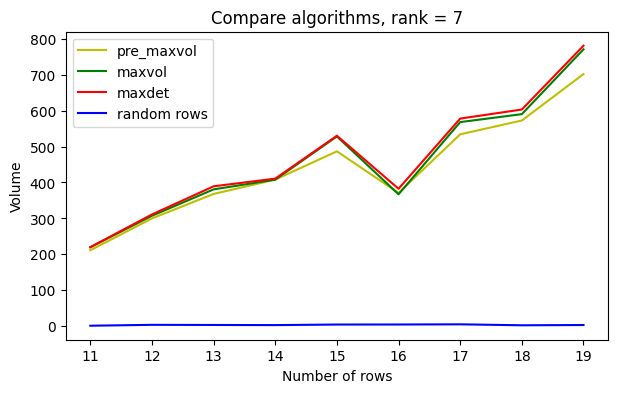

In [12]:
plotvolume(11, 20, 7)

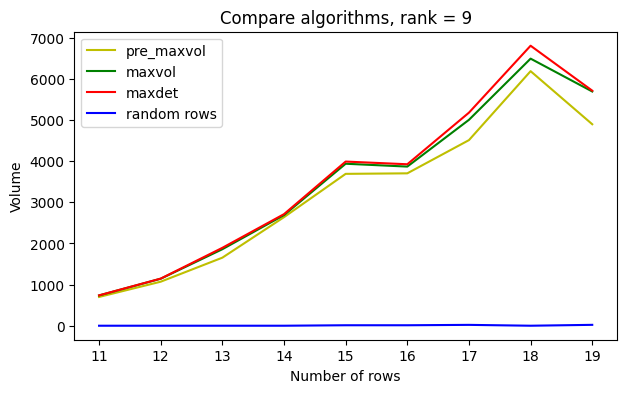

In [13]:
plotvolume(11, 20, 9)

## Compare with truncated SVD

In [14]:
def Truncated_svd(A, r):
    U, s, Vt = sp.linalg.svd(A)
    s[r:] = 0
    S = np.zeros(A.shape)
    np.fill_diagonal(S, s)
    return U @ S @ Vt

In [15]:
def plotapprox(lower, upper, step, rank):
    norms_trunc_frob = []
    norms_lowrank_frob = []
    norms_trunc_spectral = []
    norms_lowrank_spectral = []
    ind = []

    for i in range(lower, upper, step):
        ind.append(i)
        cur_trunc = []
        cur_lowrank = []
        cur_trunc_spec = []
        cur_lowrank_spec = []
        for j in range(5):
            C = np.random.randn(i, i)
            X = Truncated_svd(C, rank)
            Y = LowRankApproximation(C, rank)
            cur_trunc.append(sp.linalg.norm(X-C))
            cur_lowrank.append(sp.linalg.norm(Y-C))
            cur_trunc_spec.append(sp.linalg.norm(X-C, 2))
            cur_lowrank_spec.append(sp.linalg.norm(Y-C, 2))

        norms_trunc_frob.append(mean(cur_trunc))
        norms_lowrank_frob.append(mean(cur_lowrank))
        norms_trunc_spectral.append(mean(cur_trunc_spec))
        norms_lowrank_spectral.append(mean(cur_lowrank_spec))

    fig, ax = plt.subplots(2)
    fig.suptitle(f'Compare approximations, r = {rank}')
    ax[0].set_ylabel('Error (frobenius norm)')

    ax[0].plot(ind, norms_trunc_frob, label='truncated svd', color='r')
    ax[0].plot(ind, norms_lowrank_frob, label='our LowRankApproximation', color='g')

    ax[1].set_xlabel('Number of rows')
    ax[1].set_ylabel('Error (spectral norm)')

    ax[1].plot(ind, norms_trunc_spectral, label='truncated svd', color='r')
    ax[1].plot(ind, norms_lowrank_spectral, label='our LowRankApproximation', color='g')

    plt.legend()
    plt.show()

### Comparison of the quality of low-rank approximation using the algorithm from the article LowRankApproximation and truncated SVD

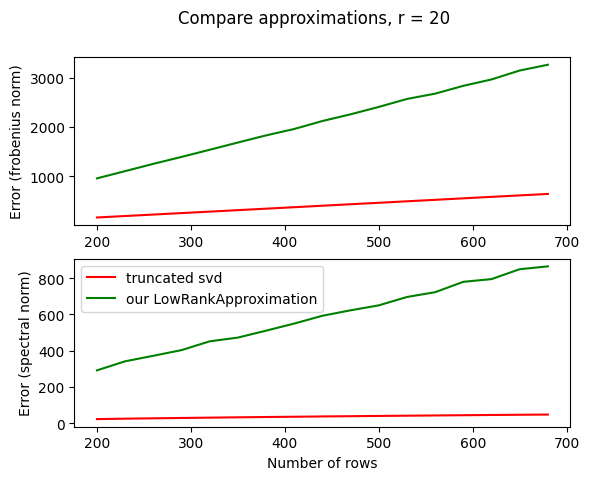

In [16]:
plotapprox(200, 700, 30, 20)

### Comparison of the running time of low-rank approximation algorithms, namely LowRankApproximation from the article and truncated SVD

In [17]:
def plottimesppr(lower, upper, step, rank):
    trunc_time = []
    lowrank_time = []
    size = []
    for i in range(lower, upper, step):
        size.append(i)
        cur_trunc_time = []
        cur_lowrank_time = []
        for j in range(5):
            C = np.random.randn(i, i)
            start1 = time.time()
            X = Truncated_svd(C, rank)
            end1 = time.time()
            cur_trunc_time.append((end1-start1) * 10 ** 3)
            start2 = time.time()
            Y = LowRankApproximation(C, rank)
            end2 = time.time()
            cur_lowrank_time.append((end2-start2) * 10 ** 3)
        trunc_time.append(mean(cur_trunc_time))
        lowrank_time.append(mean(cur_lowrank_time))

    fig, ax = plt.subplots(figsize=(7, 4))
    ax.set_xlabel('Number of rows')
    ax.set_ylabel('Time, ms')
    ax.set_title(f'Compare algorithms, rank = {rank}')

    plt.plot(size, trunc_time, label='truncated SVD', color='r')
    plt.plot(size, lowrank_time, label='Our LowRankApproximation', color='g')
    plt.legend()
    plt.show()

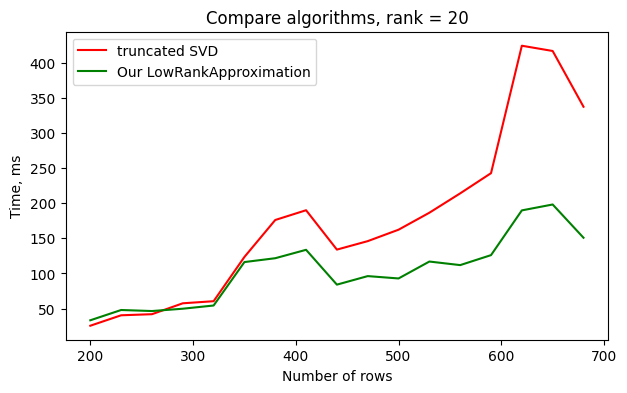

In [18]:
plottimesppr(200, 700, 30, 20)